# Crear una red neuronal convolucional
Teniendo en cuenta lo aprendido en los vídeos anteriores, vamos a crear una red neuronal convolucional. La estructura que seguiremos serán:

- Una capa convolucional 3×3 (sin paddings) seguida de una capa de MaxPooling de 2×2
- Una capa convolucional 3×3 (sin paddings) seguida de una capa de MaxPooling de 2×2
- Aplanar el resultado


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os

model = tf.keras.models.Sequential()

# Añadimos la primera capa
model.add(tf.keras.layers.Conv2D(64,(3,3), activation = 'relu', input_shape = (128,128,3)))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

# Añadimos la segunda capa
model.add(tf.keras.layers.Conv2D(64,(3,3), activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

# Hacemos un flatten para poder usar una red fully connected
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))

# Añadimos una capa softmax para que podamos clasificar las imágenes
model.add(tf.keras.layers.Dense(2, activation='softmax'))


model.compile(optimizer="rmsprop",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Ahora que ya tenemos el modelo creado vamos a:

- Reclasificar las etiquetas del df en perro y gato.
- Crear df de train y test.
- Generador de batches y aplicación de data agumentation

Como veréis, si bien los dos primeros pasos son similares a lo que haríamos en una red neuronal normal, el tercero paso es algo nuevo. Y es que, **tratar con imágenes es un proceso que requiere de mucha memoria, por lo que no podemos hacerlo todo de golpe, sino que tenemos que hacerlo por lotes o o batches.**

Además, podemos aplicar ciertas distorsiones a la imagen (zoom, darle la vuelta, etc.) para crear una imagen nueva y así aumentar nuestro dataset de entrenamiento. Todo esto lo hacemos con la función ImageDataGenerator de Keras.

In [ ]:
import os
from sklearn.model_selection import train_test_split
filenames = os.listdir("../input")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

# Convertimos la variable category en Gato o Perro
df["category"] = df["category"].replace({0: 'gato', 1: 'perro'})

# Creamos los df de train y test con un split del 75-25
df_train, df_test = train_test_split(df, test_size=0.25, random_state=42)


# Creamos unas modificaciones sobre las imágenes para tener más cantidad de
# imágenes con las que entrenar.
datos_train = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,        # Normalizar la imagen
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Generador de imágenes
tamaño_batch = 15
generador_train = datos_train.flow_from_dataframe(
    df_train,
    "input/",
    x_col='filename',
    y_col='category',
    target_size= (128,128),
    class_mode= 'categorical',
    batch_size= tamaño_batch
)


# Repetimos el proceso para test
datos_test =  tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
generador_test = datos_test.flow_from_dataframe(
    df_test,
    "input/",
    x_col='filename',
    y_col='category',
    target_size=(128,128),
    class_mode='categorical',
    batch_size=tamaño_batch
)

Ya con esto podemos entrenar el modelo.

In [ ]:
epochs=3
historia = model.fit_generator(
    generador_train,
    epochs=epochs,
    validation_data=generador_test,
    validation_steps=df_test.shape[0]//tamaño_batch,
    steps_per_epoch=df_train.shape[0]//tamaño_batch
)

Con esto ya tendríamos creada nuestro clasificador de imágenes. Ya solo queda ver cómo ha ido aprendiendo nuestra red neuronal convolucional hecha en Keras.

In [ ]:
import matplotlib.pyplot as plt

acc = historia.history['accuracy']
epochs = range(epochs)
plt.plot(epochs, acc)
plt.title('Training and validation loss')

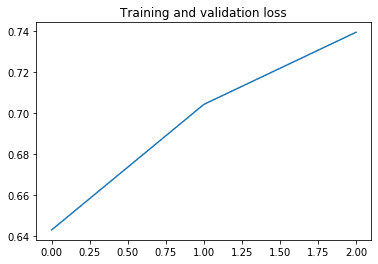

Como ves, en solo 3 epochs, nuestra red neuronal convolucional ha conseguido aprender y tener una tasa de acierto de casi el 75%, lo cual para tan pocas vueltas, está muy bien.